# 以上为简单分析,未使用时间序列分析法.下面将从时间序列角度,分析预测数据

# 数据与时间相关,不能采用独立的线性回归模型

## 如果数据某些统计特性(均值/方差等),能随时间维持相对恒定,那么,可用时间序列分析法预测

### 查看数据类型

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'D:\liuchaochao\桌面\大三上\数据分析\电力系统\电力系统负荷预测分析-全部数据\附件1-区域15分钟负荷数据.csv',
                  encoding = 'utf-8')

#data = pd.read_csv(r'D:\liuchaochao\桌面\大三上\数据分析\电力系统\电力系统负荷预测分析-全部数据\test1.csv')
#默认行号为索引
print(data.head())
data.dtypes

            数据时间    总有功功率（kw）
0  2018/1/1 0:00  244033.7682
1  2018/1/1 0:15  232720.6402
2  2018/1/1 0:30  231685.6891
3  2018/1/1 0:45  227581.3317
4  2018/1/1 1:00  233482.4269


数据时间          object
总有功功率（kw）    float64
dtype: object

### 将表中数据时间转化为标准时间类型

In [46]:
import datetime
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y/%m/%d %H:%M')
data = pd.read_csv('D:\liuchaochao\桌面\大三上\数据分析\电力系统\电力系统负荷预测分析-全部数据\附件1-区域15分钟负荷数据.csv',
                   parse_dates=['数据时间'], 
                   #index_col='数据时间',#设置时间为索引
                   date_parser=dateparse,
                  encoding = 'utf-8')
print ('\n Parsed Data:')
print (data.head())


 Parsed Data:
                 数据时间    总有功功率（kw）
0 2018-01-01 00:00:00  244033.7682
1 2018-01-01 00:15:00  232720.6402
2 2018-01-01 00:30:00  231685.6891
3 2018-01-01 00:45:00  227581.3317
4 2018-01-01 01:00:00  233482.4269


### 原始数据变化趋势图

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128156 entries, 0 to 128155
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   数据时间       128156 non-null  datetime64[ns]
 1   总有功功率（kw）  128156 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


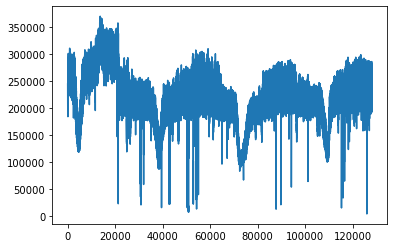

In [48]:
ts = data['总有功功率（kw）']
plt.plot(ts)

### 可见数据在2019年后，每年趋势都相似，但每年中存在季节性变化

### 绘制移动方差均值图

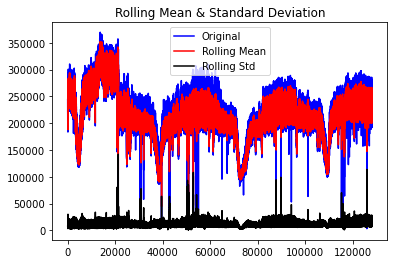

Results of Dickey-Fuller Test:
Test Statistic                -6.674614e+00
p-value                        4.497899e-09
#Lags Used                     7.200000e+01
Number of Observations Used    1.280830e+05
Critical Value (1%)           -3.430401e+00
Critical Value (5%)           -2.861563e+00
Critical Value (10%)          -2.566782e+00
dtype: float64


In [49]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()#计算窗口大小为20的均值
    rolstd = timeseries.rolling(window=20).std()#计算窗口大小为20的方差

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')#原始数据
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')#20均值数据
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')#20方差数据
    plt.legend(loc='best')#自动调整图例位置
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
test_stationarity(ts)


### 图像曲线不平稳原因主要有:每天时间;季节变化

#### 基本原理是对时间序列中的趋势和季节性建模或估计，
#### 并将其从序列中删除以得到固定的时间序列。
#### 然后在该时间序列上实施统计预测技术。
#### 最后一步则是通过应用趋势和季节性约束将预测值转换为原始比例。

### 对数转换,来放大值的特性,减小趋势

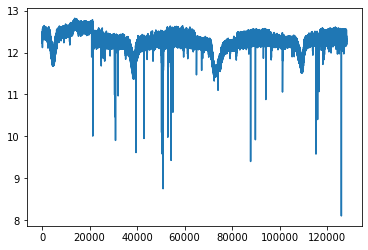

In [50]:
ts_log = np.log(ts)
plt.plot(ts_log)

### 移动平均,来消除某些例外的值,

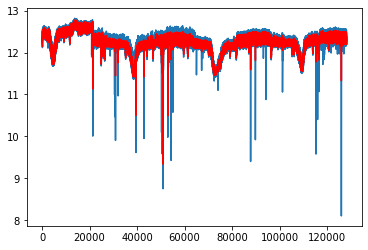

In [51]:
moving_avg = ts_log.rolling(20).mean()#20个连续值的平均值
plt.plot(ts_log)
plt.plot(moving_avg,color ='red')

### 红线表示移动平均值。我们把它从原始时间序列中减去。
### 并且，由于我们取的是最近20个值的平均值，因此前19个值没有定义移动平均值。

### 用此点前20个点的平均值代替此点的值

In [53]:
ts_log_moving_avg_diff = ts_log - moving_avg 
ts_log_moving_avg_diff.head(25)


0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19   -0.026541
20   -0.017262
21    0.060857
22   -0.035970
23    0.066249
24   -0.004414
Name: 总有功功率（kw）, dtype: float64

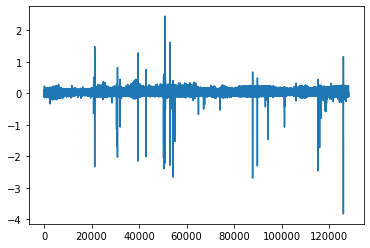

In [54]:
plt.plot(ts_log_moving_avg_diff)

### 先删除这些NaN值，再检查平稳性

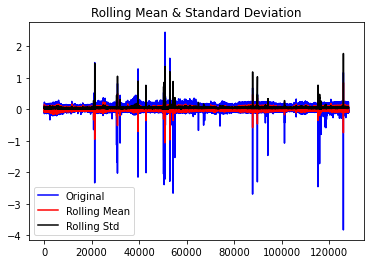

Results of Dickey-Fuller Test:
Test Statistic                    -80.343140
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128064.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [55]:
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

### 指数加权移动平均

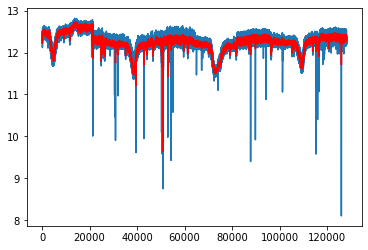

In [56]:
expwighted_avg = pd.DataFrame.ewm(ts_log,halflife = 20).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg,color ='red')

### 检查修改后数据的平稳性

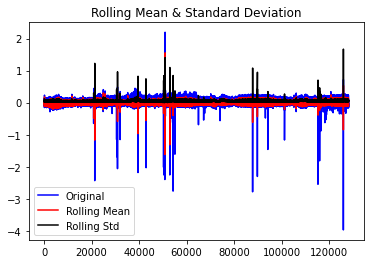

Results of Dickey-Fuller Test:
Test Statistic                    -53.282379
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128083.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [57]:
ts_log_ewma_diff = ts_log - expwighted_avg 
test_stationarity(ts_log_ewma_diff)

### 使用一次偏移进行差异化

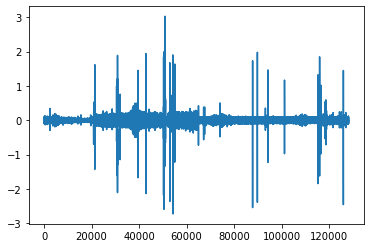

In [58]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

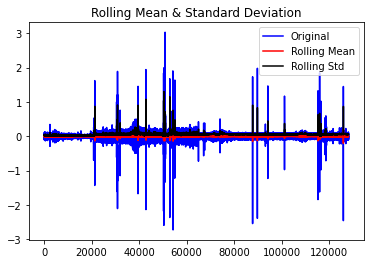

Results of Dickey-Fuller Test:
Test Statistic                    -77.401714
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128082.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [59]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

### 对趋势和季节性分别建模，然后返回序列的残余部分。

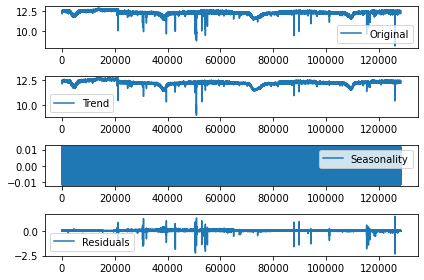

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,period = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 趋势，季节性和数据已分离，再检查残差的平稳性

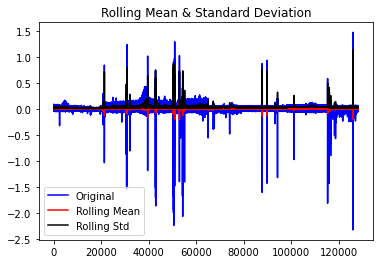

Results of Dickey-Fuller Test:
Test Statistic                    -76.361554
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128073.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [61]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### 预测时间序列

### 差分后，绘制TS的ACF和PACF图

D:\liuchaochao\DownLoad\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


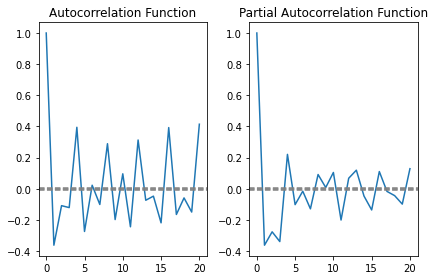

In [62]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In [63]:
###  AR Model

D:\liuchaochao\DownLoad\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'RSS: 698.9334')

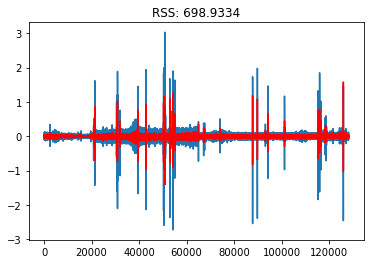

In [64]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))


In [65]:
### MA Model

Text(0.5, 1.0, 'RSS: 672.0641')

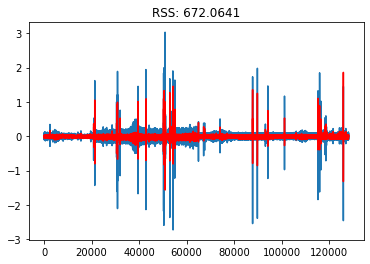

In [66]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))


In [67]:
### Combined Model

In [68]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


MemoryError: Unable to allocate 122. GiB for an array with shape (128083, 128083) and data type float64

In [ ]:
### 恢复到原始比例

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))
